<a href="https://colab.research.google.com/github/KamilS25/ISiT/blob/main/Pr2_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Практическая работа №2**. Граф. Оценка графа.

**Группа**: БСМО-11-25

**Рабочая группа**: Салахетдинов Камиль, Пылин Олег, Дели Валерия, Мокрецов Егор(БСМО-12-25)

В ячейке ниже осуществляется запрос по API ВК для того, чтобы получить данных о всех челнах группы, максимальное количество друзей берется 250, чтобы не перенасыщать граф. Между друзьями выстраиваются связи для дальнейшего построения ребер между вершинами. После чего эти данные записываются в файл (это сделано для того, чтобы экономить время, так как запрос из ВК занимает достаточное количество времени).
Данный вариант кода (обработка всех общих друзей и построение между ними графа, занимает слишком много времени, у меня выполняется уже 2.2 часа, так как слишком большой перебор необходимо для этого выполнить) слишком долго выполняется, поэтому принято решение использовать более простую вариацию перебора и построение графа.

In [1]:
# Токен: 63353a6463353a6463353a6430600efaf86633563353a640bc770f01f0254604d410cf0
import requests
import os
import time
from itertools import combinations

def get_user_info(user_id, fields, token, api_version):
    '''
    Получить информацию о человеке по его user_id
    '''
    params = {'user_id': int(user_id),
              'fields': ','.join(fields),
              'name_case': 'Nom',
              'v': api_version,
              'access_token': token}
    url = 'https://api.vk.com/method/users.get'

    try:
        req = requests.get(url, params=params)
        user = req.json()['response'][0]
    except:
        raise ValueError('Wrong user id or server error')

    return user

def make_dict_from_user_info(user, user_type):
    '''
    Обработать API ответ от сервера для удобного отображения
    '''
    user_info = {}

    user_info['id'] = str(user['id'])
    user_info['name'] = (user['first_name'] + ' ' + user['last_name']).strip()
    user_info['type'] = str(user_type)
    user_info['domain'] = 'vk.com/' + user['domain']

    return user_info

def make_node_from_user_info(user_info):
    # Преобразовать словарь с информацией о человеке в вершину графа

    new_node = []
    for key in user_info:
        new_node.append(str(user_info[key]))
    new_node = ','.join(new_node)
    return new_node

def write_to_csv(filename, fields, rows):
    '''
    Записать информацию в csv файл
    '''
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(fields + '\n')
        for row in rows:
            file.write(row + '\n')

def request_friends(user_id, count, fields, token, api_version):
    '''
    Получить список друзей человека по его user_id
    '''
    url = 'https://api.vk.com/method/friends.get'
    params = {'v': api_version,
              'access_token': token,
              'user_id': user_id,
              'count': count,
              'fields': ','.join(fields)}
    return requests.get(url, params=params).json()['response']

def get_mutual_friends(source_uid, target_uid, token, api_version):
    '''
    Получить общих друзей между двумя пользователями
    '''
    url = 'https://api.vk.com/method/friends.getMutual'
    params = {'v': api_version,
              'access_token': token,
              'source_uid': source_uid,
              'target_uid': target_uid}
    try:
        response = requests.get(url, params=params).json()
        if 'response' in response:
            return response['response']
        else:
            return []
    except:
        return []

# Инициализация токена
token = "63353a6463353a6463353a6430600efaf86633563353a640bc770f01f0254604d410cf0"

# Версия API и запрашиваемые поля
version = '5.131'
fields = ['sex', 'bdate', 'city', 'country', 'domain']

# Инициализация
while True:
    user_id = "61398554"

    try:
        user = get_user_info(user_id, fields, token, version)
        user = make_dict_from_user_info(user, 'me')
        break
    except ValueError:
        continue

print('Ваше имя:', user.get('name'))

while True:
    try:
        print('Введите максимальное количество друзей для одного человека')
        print('(рекомендуется 100-250)')
        count = int(input('Ваш выбор: '))
        break
    except:
        print('Ошибка ввода, повторите.')

# ID Группы
target_friend_ids = ['240256443', '488546338', '326869471']

print('Получение информации о группе...')

# Словарь для хранения всех пользователей
all_users = {}

all_users[user_id] = user

# Получаем информацию о группе
target_friends = []
for friend_id in target_friend_ids:
    try:
        friend_data = get_user_info(friend_id, fields, token, version)
        friend_info = make_dict_from_user_info(friend_data, 'target_friend')
        all_users[friend_id] = friend_info
        target_friends.append(friend_info)
        print(f'Получена информация о: {friend_info["name"]}')
        time.sleep(0.5)
    except Exception as e:
        print(f'Ошибка получения информации о {friend_id}: {e}')

print('Получение моих друзей...')
try:
    my_friends_response = request_friends(user_id, count, fields, token, version)
    my_friends = my_friends_response['items']
    print(f'Количество моих друзей: {len(my_friends)}')

    # Добавляем друзей моих друзей
    for friend in my_friends:
        friend_info = make_dict_from_user_info(friend, 'my_friend')
        all_users[str(friend['id'])] = friend_info
except Exception as e:
    print(f'Ошибка получения моих друзей: {e}')
    my_friends = []

# Получаем друзей для каждого из группы
for target_friend in target_friends:
    friend_id = target_friend['id']
    print(f'Получение друзей для {target_friend["name"]}...')

    try:
        friend_friends_response = request_friends(friend_id, count, fields, token, version)
        friend_friends = friend_friends_response['items']
        print(f'Количество друзей у {target_friend["name"]}: {len(friend_friends)}')

        # Добавляем друзей человека из группы
        for ffriend in friend_friends:
            ffriend_id = str(ffriend['id'])
            if ffriend_id not in all_users:
                ffriend_info = make_dict_from_user_info(ffriend, 'friend_of_target')
                all_users[ffriend_id] = ffriend_info

        time.sleep(0.5)
    except Exception as e:
        print(f'Ошибка получения друзей для {target_friend["name"]}: {e}')

print('Построение связей между друзьями...')

# Создаем списки для вершин и ребер
nodes = []
edges = []

# Добавляем всех пользователей в список вершин
for user_data in all_users.values():
    nodes.append(make_node_from_user_info(user_data))

# Создаем связи: я -> группа
for friend in my_friends:
    friend_id = str(friend['id'])
    if friend_id in all_users:
        edges.append(f"{user_id},{friend_id},2")  # вес 2 для прямых друзей

# Создаем связи: группа -> их друзья
for target_friend in target_friends:
    friend_id = target_friend['id']
    try:
        friend_friends_response = request_friends(friend_id, count, fields, token, version)
        friend_friends = friend_friends_response['items']

        for ffriend in friend_friends:
            ffriend_id = str(ffriend['id'])
            if ffriend_id in all_users:
                edges.append(f"{friend_id},{ffriend_id},1")  # вес 1 для друзей друзей

        time.sleep(0.5)
    except:
        continue

print('Поиск общих друзей между всеми пользователями...')

# Получаем список всех ID пользователей в графе
all_user_ids = list(all_users.keys())

# Для каждой пары пользователей проверяем общих друзей
for i, user1_id in enumerate(all_user_ids):
    for user2_id in all_user_ids[i+1:]:
        try:
            mutual_friends = get_mutual_friends(user1_id, user2_id, token, version)
            # Если есть общие друзья, создаем связь между пользователями
            if mutual_friends:
                # Вес связи зависит от количества общих друзей
                weight = min(len(mutual_friends), 5)  # ограничиваем вес для визуализации
                edges.append(f"{user1_id},{user2_id},{weight}")

            time.sleep(0.1)  # небольшая задержка чтобы не превысить лимиты API

        except Exception as e:
            continue

    print(f'Проверка общих друзей: {i+1}/{len(all_user_ids)}', end='\r')

print('\nЗапись данных в файлы...')

# Записываем вершины
print(f'Количество вершин: {len(nodes)}. Запись в файл nodes.csv')
write_to_csv('nodes.csv', 'id,label,type,sex,domain,country,city,bdate', nodes)

# Записываем ребра
print(f'Количество рёбер: {len(edges)}. Запись в файл edges.csv')
write_to_csv('edges.csv', 'source,target,weight', edges)


print('\nСтатистика графа:')
print(f'- Всего пользователей: {len(all_users)}')
print(f'- Я: 1')
print(f'- Группа: {len(target_friends)}')
print(f'- Мои друзья: {len(my_friends)}')
print(f'- Всего связей: {len(edges)}')


Ваше имя: Kamil Salakhetdinov
Введите максимальное количество друзей для одного человека
(рекомендуется 100-250)
Ваш выбор: 250
Получение информации о группе...
Получена информация о: Egor Mokretsov
Получена информация о: Oleg Pylin
Получена информация о: Valeria Deli
Получение моих друзей...
Количество моих друзей: 250
Получение друзей для Egor Mokretsov...
Количество друзей у Egor Mokretsov: 250
Получение друзей для Oleg Pylin...
Количество друзей у Oleg Pylin: 123
Получение друзей для Valeria Deli...
Количество друзей у Valeria Deli: 250
Построение связей между друзьями...
Поиск общих друзей между всеми пользователями...


KeyboardInterrupt: 

В ячейке выше осуществили прерывание, в ячейке ниже указана более простая реализация нахождения связей для построения графа (здесь мы не учитываем абсолютно всех общих друзей).

In [2]:
import requests
import os
import time

def get_user_info(user_id, fields, token, api_version):
  '''
  Получить информацию о человеке по его user_id
  '''

  params = {'user_id' : int(user_id),
              'fields' : ','.join(fields),
              'name_case' : 'Nom',
              'v' : api_version,
              'access_token' : token}
  url = 'https://api.vk.com/method/users.get'

  try:
      req = requests.get(url, params=params)
      user = req.json()['response'][0]
  except:
      raise ValueError('Wrong user id or server error')

  return user

def make_dict_from_user_info(user, user_type):
  '''
  Обработать API ответ от сервера для удобного отображения
  '''

  user_info = {}

  # Обязательные поля
  user_info['id'] = str(user['id'])
  user_info['name'] = (user['first_name'] + ' ' + user['last_name']).strip()
  user_info['type'] = str(user_type)
  user_info['domain'] = 'vk.com/' + user['domain']

  return user_info

def make_node_from_user_info(user_info):
  # Преобразовать словарь с информацией о человеке в вершину графа

  new_node = []
  for key in user_info:
    new_node.append(user_info[key])
  new_node = ','.join(new_node)

  return new_node

def write_to_csv(filename, fields, rows):
  '''
  Записать информацию в csv файл
  '''

  with open(filename, 'w', encoding='utf-8') as file:
    file.write(fields + '\n')
    for row in rows:
      file.write(row + '\n')

def request_friends(user_id, count, fields, token, api_version):
  '''
  Получить список друзей человека по его user_id
  '''

  url = f'https://api.vk.com/method/friends.get'
  params = {'v' : api_version,
            'access_token' : token,
            'user_id' : user_id,
            'count' : count,
            'fields' : ','.join(fields)}
  return requests.get(url, params=params).json()['response']

def is_mutual(friend, my_friends) -> bool:
  '''
  Проверить, есть ли человек в списке друзей
  '''

  for person in my_friends:
    if person['id'] == friend['id']:
      return True
  return False

# Инициализация токена
token = "63353a6463353a6463353a6430600efaf86633563353a640bc770f01f0254604d410cf0"


# Версия API и запрашиваемые поля
version = '5.131'
fields = ['domain']

# Инициализация моего аккаунта
while True:
  user_id = 61398554
  print('Получение информации об аккаунте')

  try:
    # Получить информацию о человеке по ID
    user = get_user_info(user_id, fields, token, version)
    user = make_dict_from_user_info(user, 'me')
    break
  except ValueError:
    print('Не удалось получить информацию')
    continue

print('Имя:', user.get('name'))

while True:
  try:
    print('Введите максимальное количество друзей для одного человека')
    print('(рекомендуется 100-250)')
    count = int(input('Ваш выбор: '))
    break
  except:
    print('Ошибка ввода, повторите.')

# ID Группы
target_friend_ids = ['240256443', '488546338', '326869471']

print('Получение информации о группе...')

# Словарь для хранения всех пользователей
all_users = {}

all_users[user_id] = user

# Получаем информацию о группе
target_friends = []
for friend_id in target_friend_ids:
    try:
        friend_data = get_user_info(friend_id, fields, token, version)
        friend_info = make_dict_from_user_info(friend_data, 'target_friend')
        all_users[friend_id] = friend_info
        target_friends.append(friend_info)
        print(f'Получена информация о: {friend_info["name"]}')
        time.sleep(0.5)
    except Exception as e:
        print(f'Ошибка получения информации о {friend_id}: {e}')

print('Получение моих друзей...')
try:
    my_friends_response = request_friends(user_id, count, fields, token, version)
    my_friends = my_friends_response['items']
    print(f'Количество моих друзей: {len(my_friends)}')

    # Добавляем друзей моих друзей
    for friend in my_friends:
        friend_info = make_dict_from_user_info(friend, 'my_friend')
        all_users[str(friend['id'])] = friend_info
except Exception as e:
    print(f'Ошибка получения моих друзей: {e}')
    my_friends = []

# Получаем друзей для каждого из группы
for target_friend in target_friends:
    friend_id = target_friend['id']
    print(f'Получение друзей для {target_friend["name"]}...')

    try:
        friend_friends_response = request_friends(friend_id, count, fields, token, version)
        friend_friends = friend_friends_response['items']
        print(f'Количество друзей у {target_friend["name"]}: {len(friend_friends)}')

        # Добавляем друзей человека из группы
        for ffriend in friend_friends:
            ffriend_id = str(ffriend['id'])
            if ffriend_id not in all_users:
                ffriend_info = make_dict_from_user_info(ffriend, 'friend_of_target')
                all_users[ffriend_id] = ffriend_info

        time.sleep(0.5)
    except Exception as e:
        print(f'Ошибка получения друзей для {target_friend["name"]}: {e}')

print('Построение связей между друзьями...')

# Создаем списки для вершин и ребер
nodes = []
edges = []

# Добавляем всех пользователей в список вершин
for user_data in all_users.values():
    nodes.append(make_node_from_user_info(user_data))

# Создаем связи: я -> группа
for friend in my_friends:
    friend_id = str(friend['id'])
    if friend_id in all_users:
        edges.append(f"{user_id},{friend_id},2")  # вес 2 для прямых друзей

# Создаем связи: группа -> их друзья
for target_friend in target_friends:
    friend_id = target_friend['id']
    try:
        friend_friends_response = request_friends(friend_id, count, fields, token, version)
        friend_friends = friend_friends_response['items']

        for ffriend in friend_friends:
            ffriend_id = str(ffriend['id'])
            if ffriend_id in all_users:
                edges.append(f"{friend_id},{ffriend_id},1")  # вес 1 для друзей друзей

        time.sleep(0.5)
    except:
        continue


'''
# Для каждого друга получить список его друзей
for i, friend in enumerate(my_friends):
  print(f'Получение списка друзей друзей: {i+1}/{len(my_friends)}', end='\r')

  mutual_friends = 1
  try:
      # Запрос в API
      request = request_friends(friend.get('id'), count, fields, token, version)['items']
  except:
      continue

  # Если успешно, аккаунт не закрыт
  open_accounts += 1

  # Подсчет общих друзей
  for _friend in request:
    if is_mutual(_friend, my_friends):
      mutual_friends += 1

  # Пропустить человека, если нет общих друзей и drop_without_mutuals=True
  if drop_without_mutuals and mutual_friends < 2:
    dropped += 1
    time.sleep(0.5)
    continue

  # Добавить ребра от друга до каждого его друга
  for _friend in request:
    friends_of_friends.append(_friend)
    edges.append(f"{friend['id']},{_friend['id']},1")

  # Добавить ребро до друга
  edges.append(f"{user_id},{friend['id']},{mutual_friends}")

  # Добавить друга в списко вершин
  friend = make_dict_from_user_info(friend, 'friend')
  nodes.append(make_node_from_user_info(friend))

  time.sleep(0.5)

print('\nЗакрытых аккаунтов среди друзей:', len(my_friends) - open_accounts)
if drop_without_mutuals:
  print('Пропущено друзей:', dropped)

# Добавить вершины для друзей друзей
for friend in friends_of_friends:
  friend = make_dict_from_user_info(friend, 'friend_of_friend')
  new_node = make_node_from_user_info(friend)

  if new_node not in nodes:
    nodes.append(new_node)
    '''

print(f'Количество вершин: {len(nodes)}. Запись в файл nodes.csv')
write_to_csv('nodes.csv', 'id,label,type,sex,domain,country,city,bdate', nodes)

print(f'Количество рёбер: {len(edges)}. Запись в файл edges.csv')
write_to_csv('edges.csv', 'source,target,weight', edges)

input('Готово!')

Получение информации об аккаунте
Имя: Kamil Salakhetdinov
Введите максимальное количество друзей для одного человека
(рекомендуется 100-250)
Ваш выбор: 250
Получение информации о группе...
Получена информация о: Egor Mokretsov
Получена информация о: Oleg Pylin
Получена информация о: Valeria Deli
Получение моих друзей...
Количество моих друзей: 250
Получение друзей для Egor Mokretsov...
Количество друзей у Egor Mokretsov: 250
Получение друзей для Oleg Pylin...
Количество друзей у Oleg Pylin: 123
Получение друзей для Valeria Deli...
Количество друзей у Valeria Deli: 250
Построение связей между друзьями...
Количество вершин: 852. Запись в файл nodes.csv
Количество рёбер: 873. Запись в файл edges.csv
Готово!


''

Далее строим граф и выполняем оценку центральности графа 3-мя метриками:

1. По посредничеству: мера центральности в графе, основанная на кратчайших путях. Равна числу этих кратчайших путей через вершину.

2. По близости: мера, которая выражает, насколько близко узел расположен к остальным узлам сети.

3. Собственного вектора: мера центральности вершины в графе, которая учитывает количество и качество соединений узла. Учитывает, насколько тесно узел связан с другими хорошо связанными узлами.


Топ-5 по центральности близости:
------------------------------------------------------------
 1. Valeria Deli              | my_friend       | closeness: 0.586611
 2. Kamil Salakhetdinov       | me              | closeness: 0.586207
 3. Egor Mokretsov            | my_friend       | closeness: 0.543478
 4. Darya Kondakova           | my_friend       | closeness: 0.469354
 5. Oleg Pylin                | my_friend       | closeness: 0.468062

Топ-5 по центральности посредничества:
------------------------------------------------------------
 1. Kamil Salakhetdinov       | me              | betweenness: 0.532322
 2. Valeria Deli              | my_friend       | betweenness: 0.523901
 3. Egor Mokretsov            | my_friend       | betweenness: 0.486535
 4. Oleg Pylin                | my_friend       | betweenness: 0.253925
 5. Andrey Broshevetsky       | friend_of_target | betweenness: 0.000000

Топ-5 по собственному вектору:
------------------------------------------------------------


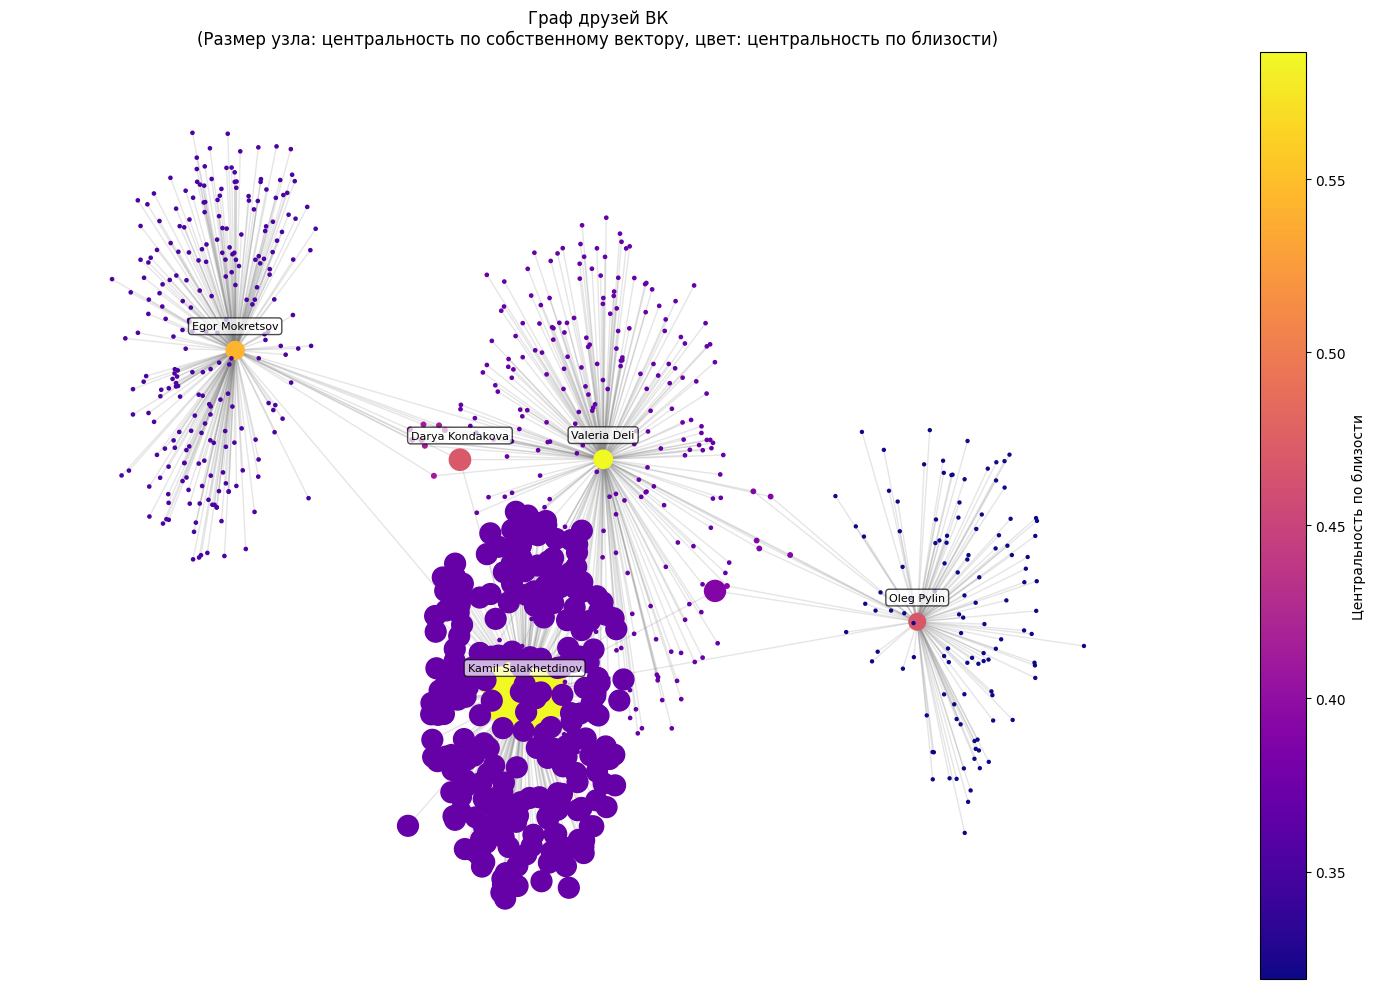

Количество узлов: 851
Количество рёбер: 869


In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Загрузка данных
edges = pd.read_csv('edges.csv')
nodes = pd.read_csv('nodes.csv', on_bad_lines='skip')

# Создание графа
G = nx.Graph()

# Добавление узлов с атрибутами
for _, row in nodes.iterrows():
    G.add_node(row['id'],
               label=row['label'],
               type=row['type'],
               domain=row['domain'])

# Добавление рёбер
for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# Вычисление центральности близости/посредничеству/собственному вектору
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G, weight='weight')
eigenvector = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Добавили результат в общую таблицу
centrality_df = pd.DataFrame({
    'node': list(closeness.keys()),
    'closeness': list(closeness.values()),
    'betweenness': list(betweenness.values()),
    'eigenvector': list(eigenvector.values())
})

# Добавление информации об узлах
node_info = nodes[['id', 'label', 'type']].drop_duplicates(subset=['id'])
centrality_df = centrality_df.merge(node_info, left_on='node', right_on='id', how='left')
centrality_df = centrality_df.drop('id', axis=1)

# Сортировка по степени центральности
closeness_sorted = centrality_df.sort_values('closeness', ascending=False)
betweenness_sorted = centrality_df.sort_values('betweenness', ascending=False)
eigenvector_sorted = centrality_df.sort_values('eigenvector', ascending=False)

# Вывод топ-5 узлов по каждой метрике
print("\nТоп-5 по центральности близости:")
print("-" * 60)
for i, (_, row) in enumerate(closeness_sorted.head(5).iterrows(), 1):
    print(f"{i:2d}. {row['label']:25} | {row['type']:15} | closeness: {row['closeness']:.6f}")

print("\nТоп-5 по центральности посредничества:")
print("-" * 60)
for i, (_, row) in enumerate(betweenness_sorted.head(5).iterrows(), 1):
    print(f"{i:2d}. {row['label']:25} | {row['type']:15} | betweenness: {row['betweenness']:.6f}")

print("\nТоп-5 по собственному вектору:")
print("-" * 60)
for i, (_, row) in enumerate(eigenvector_sorted.head(5).iterrows(), 1):
    print(f"{i:2d}. {row['label']:25} | {row['type']:15} | eigenvector: {row['eigenvector']:.6f}")

# Отображение графа моих друзей из VK
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
closeness_values = list(closeness.values())
vmin = min(closeness_values)
vmax = max(closeness_values)

nodes_draw = nx.draw_networkx_nodes(
    G, pos,
    node_size=[v * 5000 for v in eigenvector.values()],
    node_color=closeness_values,
    cmap=plt.cm.plasma,
    vmin=vmin,
    vmax=vmax
)
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray')

plt.colorbar(nodes_draw, label='Центральность по близости')

# Добавляем подписи для топ-5 самых центральных узлов
top_labels = {}
for _, row in top_overall.head(5).iterrows():
    node_id = row['node']
    if node_id in pos:
        top_labels[node_id] = row['label']

for node_id, label in top_labels.items():
    x, y = pos[node_id]
    plt.text(x, y + 0.02, label, fontsize=8, ha='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.title('Граф друзей ВК\n(Размер узла: центральность по собственному вектору, цвет: центральность по близости)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Количество узлов: {G.number_of_nodes()}")
print(f"Количество рёбер: {G.number_of_edges()}")